# HH simulation


## Table of Contents 

* Defining equations of motion

## Setup

In [28]:
import numpy as np
from scipy.optimize import fsolve
from scipy.misc import derivative
import matplotlib as mpl
import matplotlib.pyplot as plt

# For retina displays only 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [71]:
# Setting plotting defaults

# Make legend text small
plt.rcParams['legend.fontsize'] = 'small' 
# Shrink axes labels a bit 
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
# Set limits on when scientific notation is used
plt.rcParams['axes.formatter.limits'] = [-2, 3] 
# Use LaTeX to format axes labels and numbers
plt.rcParams['axes.formatter.use_mathtext'] = True
# Get rid of spines on top and bottom
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# Ticks point in  
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# Change DPI of figure images
plt.rcParams['figure.dpi'] = 300

## Defining variables and equations of motion

There are 4 variables in the HH model 

1. $V$ (membrane voltage)
2. $n$ (activation gate for K+ channel)
3. $m$ (activation gate for Na+ channel)
4. $h$ (inactivation gate for Na+ channel)

albeit with different constants depending on the gate. 

Note that in the original HH paper they had a different definition of Voltage:

$$ V_{HH} = -V + 65 $$

In [216]:
# Functions defining external current

## A static current
def static_i(t, i_0=1):
    return(i_0) 

## A step current
def step_i(t, t_s=100, i_0=0):
    if t > t_s:
        return i_0
    else:
        return 0

# Setting paramaters
## Capicitance (in micro-F/mm^2)
c = 0.010

## Conductances (in mS/mm^2)
gL = 0.003
gK = 0.036
gNa = 1.2

## Reversal potentials (in mV)
eL = -54.387 # in mV
eK = -77
eNa = 50

## Current function (in micro-A/mm^2)
i = step_i

# Membrane voltage dynamics
def dVdt(V, n, m, h, t):
    i_m = gL*(V-eL) + gK*(n**4)*(V-eK) + gNa*(m**3)*h*(V-eNa) 
    return((1./c)*(-i_m + i(t)))

# Voltage-gated channel subunit dynamics
def dndt(V, n):
    alpha = 0.01*(V + 55) / (1 - np.exp(-0.1*(V + 55)))
    beta = 0.125*np.exp(-0.0125*(V + 65))
    delta = alpha*(1.0-n) - beta*n
    return(delta) 

def dmdt(V, m):
    alpha = 0.1*(V + 40) / (1 - np.exp(-0.1*(V + 40)))
    beta = 4*np.exp(-0.0556*(V + 65))
    delta = alpha*(1.0-m) - beta*m
    return(delta) 

def dhdt(V, h):
    alpha = 0.07*np.exp(-0.05*(V + 65))
    beta = 1 / (1 + np.exp(-0.1*(V + 35)))
    delta = alpha*(1.0-h) - beta*h
    return(delta) 

# Putting the dynamics together
def dSdt(V, n, m, h, t):
    return(np.array([dVdt(V, n, m, h, t), dndt(V, n), dmdt(V, m), dhdt(V, h), 1.]))

In [217]:
# Simulation functions 
DT = 0.1

# Function implimenting the midpoint method aka RK2
def find_next_point_midpoint(s, dsdt, dt=DT):
    s_test = s + dsdt(*s)*dt
    s_next = s + dsdt(*((s + s_test)/2.))*dt
    return(s_next)

# Simulation function
def simulate(s_0, t_f, dsdt=dSdt, simulation_function=find_next_point_midpoint, dt=DT, verbose=False):
    S_solution = [s_0]
    T = np.arange(s_0[-1], t_f + dt, dt)
    for t in T[1:]:
        s_previous = S_solution[-1]
        s_next = simulation_function(s_previous, dsdt, dt=dt)
        if verbose:
            print(s_next)
        S_solution.append(s_next)
    S_solution = np.array(S_solution)
    return(S_solution)

In [225]:
S_0 = [-90, 0, 0, 0, 0]

T = 100 # in ms
S = simulate(S_0, T, verbose=False)

In [226]:
V = S[:,0]
n = S[:,1]
m = S[:,2]
h = S[:,3]
T = S[:,4]

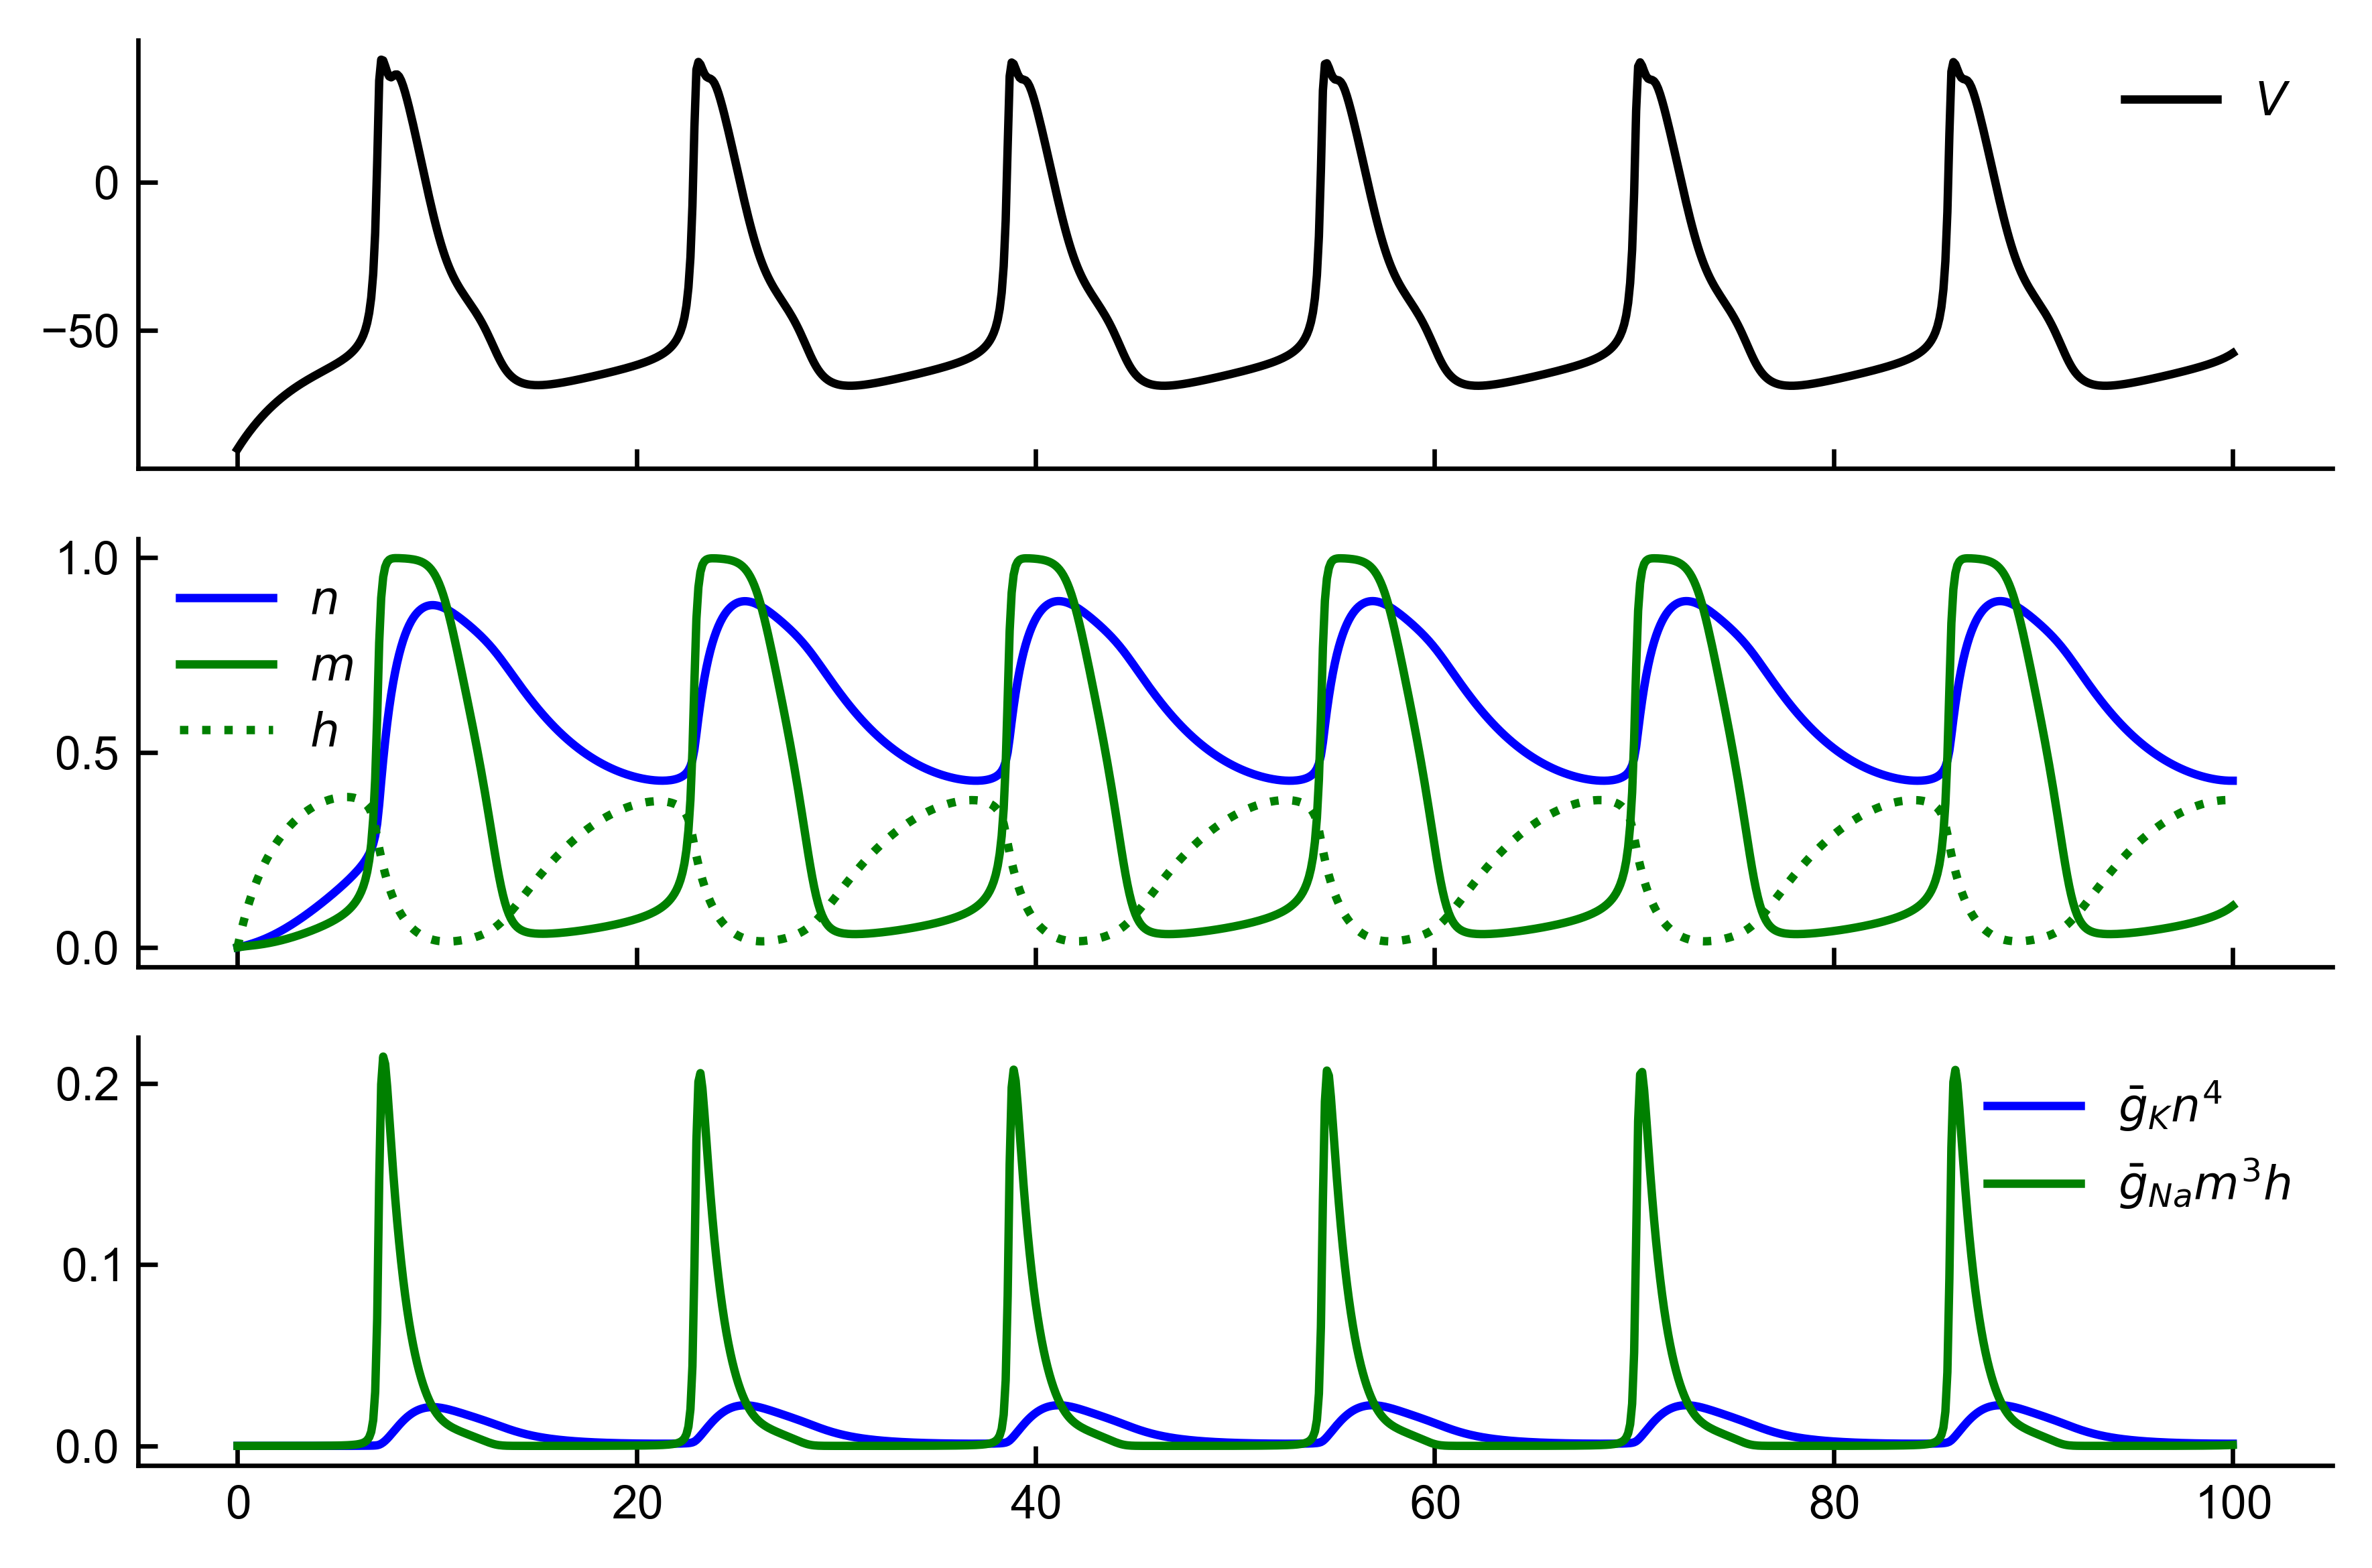

In [227]:
fig, (ax_v, ax_c, ax_c2) = plt.subplots(nrows=3, sharex=True)
ax_v.plot(T, V, label="$V$", color='k')
ax_v.legend()

ax_c.plot(T, n, c='blue', label="$n$")
ax_c.plot(T, m, c='green', label="$m$")
ax_c.plot(T, h, c='green', ls=':', label="$h$")
ax_c.legend()

ax_c2.plot(T, gK*n**4, c='blue', label="$\\bar{g}_{K} n^4$")
ax_c2.plot(T, gNa*m**3*h, c='green', label="$\\bar{g}_{Na} m^3h$")
ax_c2.legend()